In [1]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from keras.models import load_model


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle


In [2]:
from IPython.display import FileLinks, FileLink
#FileLinks(r'Data/')
#FileLink(r'./Midterm_Model.h5')

In [3]:
import shutil
import os 
#shutil.rmtree("/kaggle/working/lr0.0001_epochs220")
#os.remove('./MyModel.h5')
#os.remove('./lr0.0001_epochs220.h5')

In [4]:
# Check if tensorflow detectects the gpu or not
if tf.test.gpu_device_name():
    print("Gpu available: {}".format(tf.test.gpu_device_name()))
else:
    print("Tensor Flow has not detected the gpu")

Gpu available: /device:GPU:0


In [5]:
#inputImg = []
#inputImg.append(pd.read_csv('Data/all_lc_converted_to_test1_senior_format.csv', delimiter=','))
#imputdata = pd.read_csv('Data/all_lc_converted_to_test1_senior_format.csv', delimiter=',')
#print(len(inputImg))
# Split into train and validation set
#train_inputImg ,val_test_inputImg = train_test_split(imputdata,test_size=0.2, random_state=42)



In [6]:
# Function to preprocess the image
def preprocess_image(image):
    # Enhance edges using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Apply a bilateral filter to remove noise while keeping edges sharp
    filtered_image = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    return enhanced_image, filtered_image

(256, 256, 1)
(256, 256)


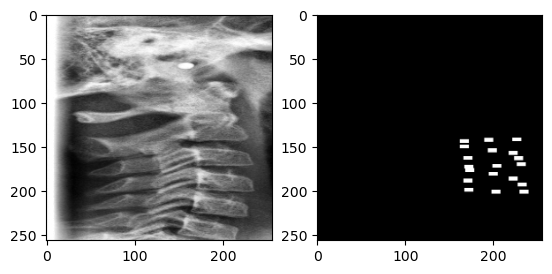

In [7]:
train_inputImg = pd.read_csv('Data/train_data.csv', delimiter=',')

w = 5
train_images = []
masks = []
train_masks = []

train_images_filtered = []


for row in train_inputImg.values:
    img_landmarks = list(row)
    image = cv2.imread('Data/ROI images/' + img_landmarks[0],0) 
    Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
    
    for i in range(1,38,2):
        x = int(img_landmarks[i])
        y = int(img_landmarks[i+1])
        Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
    
    masks.append(Mask_Image)

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    #improve the image features 
    enhanced_image, filtered_image = preprocess_image(new_image)

    train_images.append(enhanced_image/255)
    train_images_filtered.append(filtered_image/255)


    resize_mask=cv2.resize(Mask_Image,(256,256))
    train_masks.append(resize_mask)

size=new_image.shape
print(size)
print (train_images[0].shape)
plt.subplot(121)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[0], cmap='gray')

67
(256, 256, 1)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


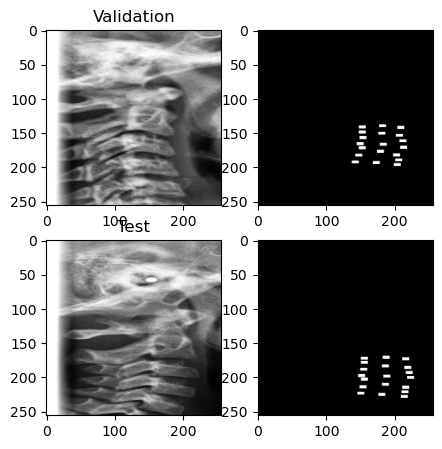

In [8]:
val_test_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')

plt.rcParams["figure.figsize"] = (5,5)

val_images = []
val_images_filtered = []
val_masks_orig = []
val_masks = []

test_images = []
test_images_filtered = []
test_masks_orig = []
test_masks = []

count = 1

print(len(val_test_inputImg))
for row in val_test_inputImg.values:
    img_landmarks = list(row)

   
    image = cv2.imread('Data/ROI images/' + img_landmarks[0], 0) 
    Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
    
    for i in range(1,38,2):
        x = int(img_landmarks[i])
        y = int(img_landmarks[i+1])
        Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
         

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    #improve the image features 
    enhanced_image, filtered_image = preprocess_image(new_image)
    resize_mask=cv2.resize(Mask_Image,(256,256))

    
    if count <= 50:
        val_images.append(enhanced_image/255)
        val_images_filtered.append(filtered_image/255)
        val_masks_orig.append(Mask_Image)
        val_masks.append(resize_mask)
    else:
        test_images.append(enhanced_image/255)
        test_images_filtered.append(filtered_image/255)
        test_masks_orig.append(Mask_Image)
        test_masks.append(resize_mask) 
    
    count += 1
    
size=new_image.shape
print(size)
print (val_masks[0].shape)
print(val_images[0].shape)
print(test_masks[0].shape)
print(test_images[0].shape)


plt.subplot(221)
plt.imshow(val_images[0], cmap='gray')
plt.title("Validation")
plt.subplot(222)
plt.imshow(val_masks[0], cmap='gray')

plt.subplot(223)
plt.imshow(test_images[0], cmap='gray')
plt.title("Test")
plt.subplot(224)
plt.imshow(test_masks[0], cmap='gray')

In [9]:
train_images_filtered_stacked = np.stack(train_images_filtered, axis=0)
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

In [10]:
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

(366, 256, 256)
(366, 256, 256)


In [11]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [12]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [13]:
# Load the model, ensuring you include the custom objects in the call
unet = load_model('Midterm_Model_1000_enhanced_images.h5', custom_objects={'dice_coeff': dice_coeff, 'dice_loss': dice_loss})

In [14]:
# Load the history from a file
with open('model_history_1000_enhanced.pkl', 'rb') as file_pi:
    model_history = pickle.load(file_pi)

with open('model_history_1000_filtered.pkl', 'rb') as file_pi:
    model_history_filtered = pickle.load(file_pi)

In [15]:
print(model_history)

{'loss': [0.9489758610725403, 0.913155734539032, 0.8940722346305847, 0.8872916102409363, 0.8771584630012512, 0.8708809018135071, 0.862662672996521, 0.8560298085212708, 0.8501396179199219, 0.842556893825531, 0.8626724481582642, 0.846653401851654, 0.8423261642456055, 0.8302620053291321, 0.8221257925033569, 0.816342830657959, 0.8261750936508179, 0.8157375454902649, 0.8000999093055725, 0.7921629548072815, 0.7838857173919678, 0.78030925989151, 0.7752950191497803, 0.7819325923919678, 0.7800776958465576, 0.7704882025718689, 0.8218277096748352, 0.7843528389930725, 0.7742339968681335, 0.7672469615936279, 0.7565151453018188, 0.750700831413269, 0.7412629127502441, 0.7415391206741333, 0.7331739068031311, 0.7331645488739014, 0.726574182510376, 0.7276210188865662, 0.7282453179359436, 0.7166104316711426, 0.7109854221343994, 0.7092347145080566, 0.7037968039512634, 0.7035189270973206, 0.7138186097145081, 0.7024250626564026, 0.7059204578399658, 0.7024486064910889, 0.6881747245788574, 0.6783556938171387,

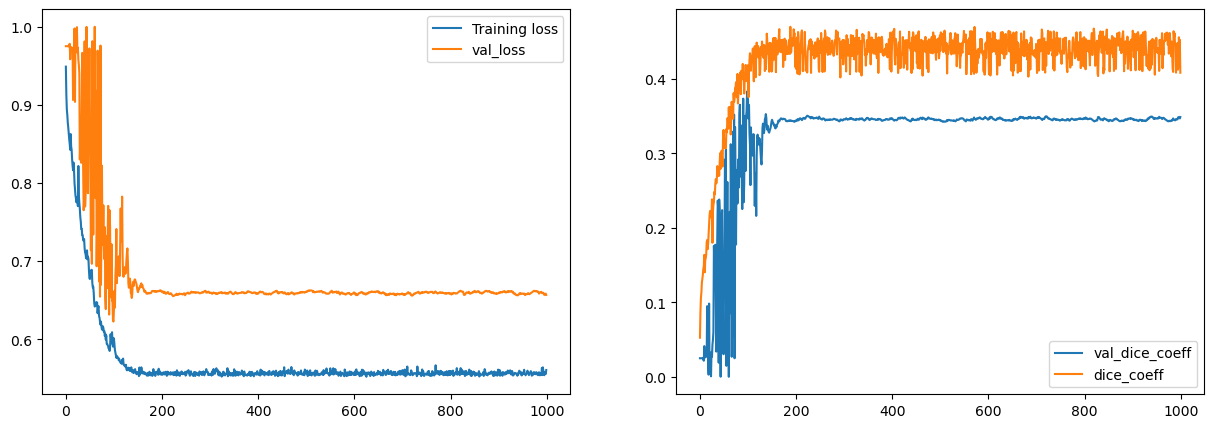

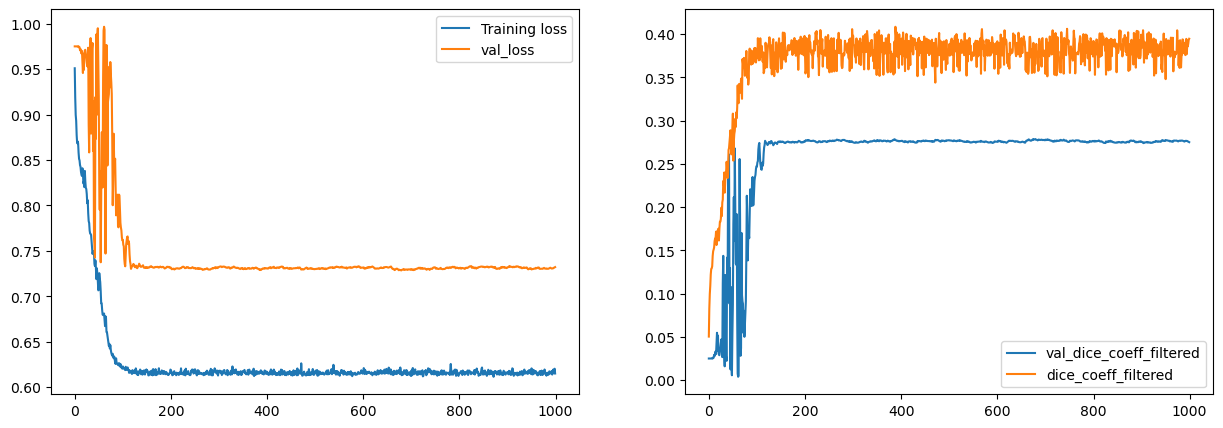

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(model_history['loss'])
ax1.plot(model_history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(model_history['val_dice_coeff'])
ax2.plot(model_history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])



fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(15,5))

ax3.plot(model_history_filtered['loss'])
ax3.plot(model_history_filtered['val_loss'])
ax3.legend(['Training loss', 'val_loss'])

ax4.plot(model_history_filtered['val_dice_coeff'])
ax4.plot(model_history_filtered['dice_coeff'])
ax4.legend(['val_dice_coeff_filtered', 'dice_coeff_filtered'])


In [17]:
test_images_stacked = np.stack(test_images, axis=0)
test_masks_stacked = np.stack(test_masks, axis=0)

test_images_filtered_stacked = np.stack(test_images_filtered, axis=0)


In [18]:
pred_masks = unet.predict(test_images_stacked)

1/1 [==============================] - 3s 3s/step


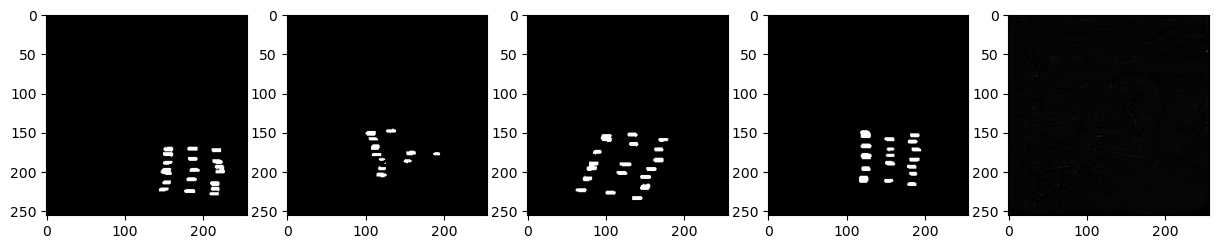

In [19]:
plt.rcParams["figure.figsize"] = (15,15)
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(pred_masks[i-1], cmap='gray')

(256, 256)
(256, 256, 3)


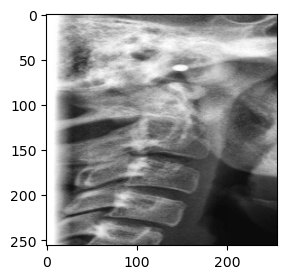

In [20]:
plt.rcParams["figure.figsize"] = (3,3)
idx = 2
print(test_images_stacked[idx].shape)
test_im_gray = test_images_stacked[idx]   # dimension (256, 256, 1)
test_im_gray_convert = test_im_gray[:,:].astype(np.float32) # cv2 accepts dimension(256,256) and float32
# convert to RGB
test_im_rgb = cv2.cvtColor(test_im_gray_convert, cv2.COLOR_GRAY2RGB) 
print(test_im_rgb.shape)
plt.imshow(test_im_rgb)

In [21]:
print(pred_masks.shape)
print(pred_masks[0].shape)
print(pred_masks[0][0].shape)
print(pred_masks[0][:,:,0].shape)

(17, 256, 256, 1)
(256, 256, 1)
(256, 1)
(256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


max:  1.8745098
min:  0.039215688
Unique1:  [0.03921569 0.04313726 0.04705882 0.05098039 0.05490196 0.05882353
 0.0627451  0.06666667 0.07058824 0.07450981 0.07843138 0.08235294
 0.08627451 0.09019608 0.09411765 0.09803922 0.10196079 0.10588235
 0.10980392 0.11372549 0.11764706 0.12156863 0.1254902  0.12941177
 0.13333334 0.13725491 0.14117648 0.14509805 0.14901961 0.15294118
 0.15686275 0.16078432 0.16470589 0.16848959 0.16862746 0.17254902
 0.1764706  0.18039216 0.18431373 0.18809743 0.1882353  0.19215687
 0.19607843 0.2        0.20392157 0.20784314 0.21176471 0.21568628
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313726 0.24705882 0.2509804  0.25476408 0.25490198 0.25882354
 0.2627451  0.26666668 0.270481   0.27058825 0.27450982 0.27832416
 0.2784314  0.28235295 0.28627452 0.2901961  0.2935202  0.29411766
 0.29803923 0.3019608  0.30588236 0.30980393 0.3137255  0.31764707
 0.32156864 0.3254902  0.32941177 0.33333334 0.33456767 0.3372549
 0.34057903 0.34062

Text(0.5, 1.0, 'Predicted Mask')

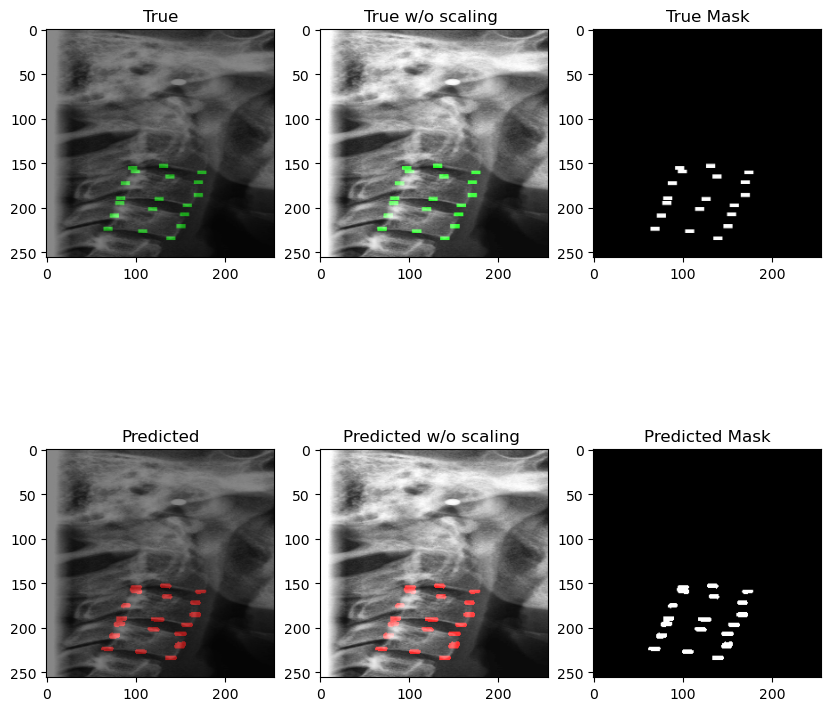

In [22]:
plt.rcParams["figure.figsize"] = (10,10)

im_copy = test_im_rgb.copy()

test_im_rgb[:,:,1] = test_im_rgb[:,:,1] + test_masks[idx]
maxValue1 = np.amax(test_im_rgb)
minValue1 = np.amin(test_im_rgb)
print("max: ", maxValue1)
print("min: ", minValue1)
print("Unique1: ",np.unique(test_im_rgb))
plt.subplot(231)
plt.imshow(test_im_rgb/maxValue1)
plt.title("True")


plt.subplot(232)
plt.imshow(test_im_rgb)
plt.title("True w/o scaling ")

plt.subplot(233)
plt.imshow(test_masks[idx], cmap='gray')
plt.title("True Mask")

im_copy[:,:,0] = im_copy[:,:,0] + pred_masks[idx][:,:,0]
maxValue2 = np.amax(im_copy)
minValue2 = np.amin(im_copy)
print("max: ", maxValue2)
print("min: ", minValue2)
print("Uniqueeee2: ",np.unique(im_copy))
plt.subplot(234)
plt.imshow(im_copy/maxValue2)
plt.title("Predicted")

plt.subplot(235)
plt.imshow(im_copy)
plt.title("Predicted w/o scaling ")

plt.subplot(236)
plt.imshow(pred_masks[idx], cmap='gray')
plt.title("Predicted Mask")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted Mask')

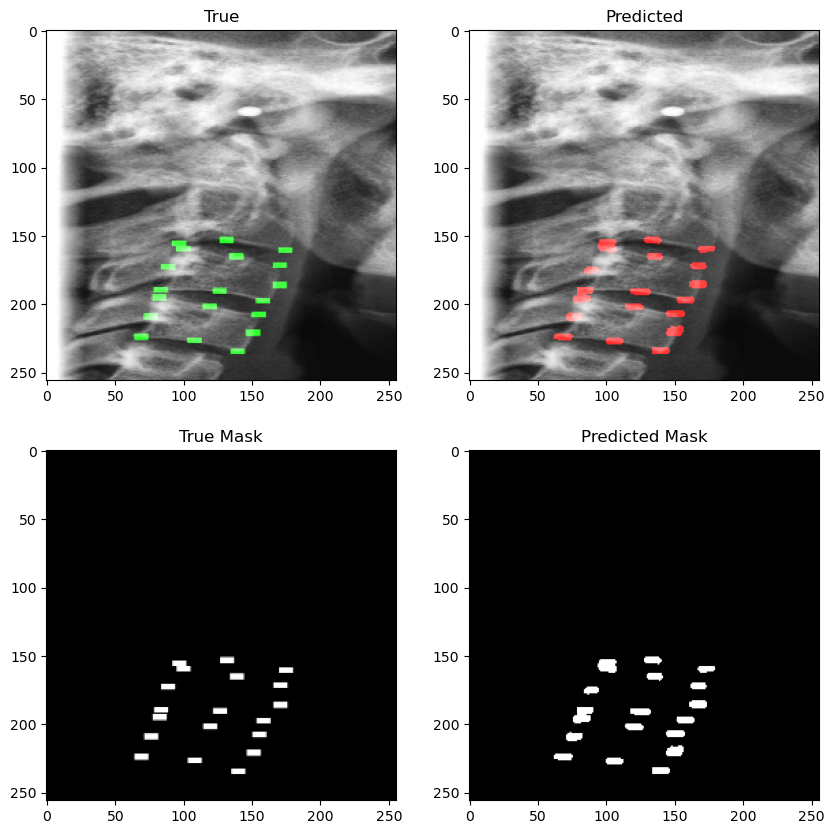

In [23]:
plt.subplot(221)
plt.imshow(test_im_rgb)
plt.title("True")

plt.subplot(222)
plt.imshow(im_copy)
plt.title("Predicted")

plt.subplot(223)
plt.imshow(test_masks[idx], cmap='gray')
plt.title("True Mask")

plt.subplot(224)
plt.imshow(pred_masks[idx], cmap='gray')
plt.title("Predicted Mask")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


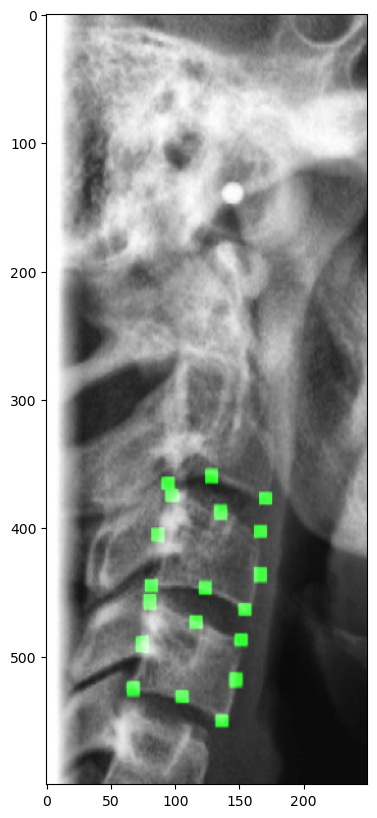

In [24]:
resized = cv2.resize(test_im_rgb, (250,600))
plt.imshow(resized)

In [25]:
origi_img = cv2.imread('Data/ROI images/LC (80).jpg') / 255
print(origi_img.shape)
print(test_masks_orig[0].shape)

(600, 250, 3)
(600, 250, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


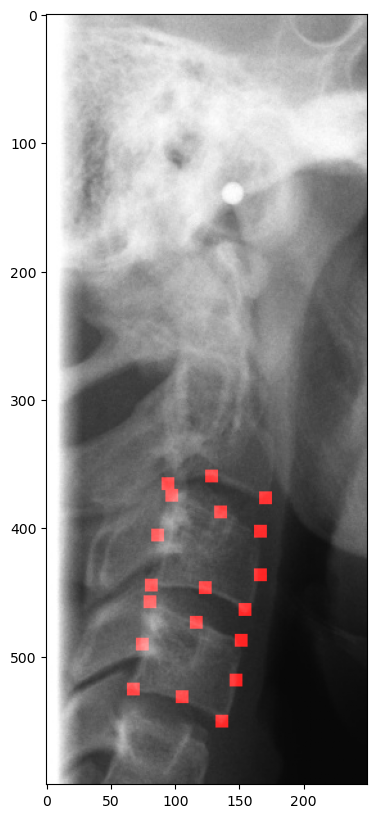

In [26]:
origi_img[:,:,0] = origi_img[:,:,0] + test_masks_orig[idx][:,:,0]
plt.imshow(origi_img)

In [27]:
im_copy_resized = cv2.resize(im_copy, (250,600))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted')

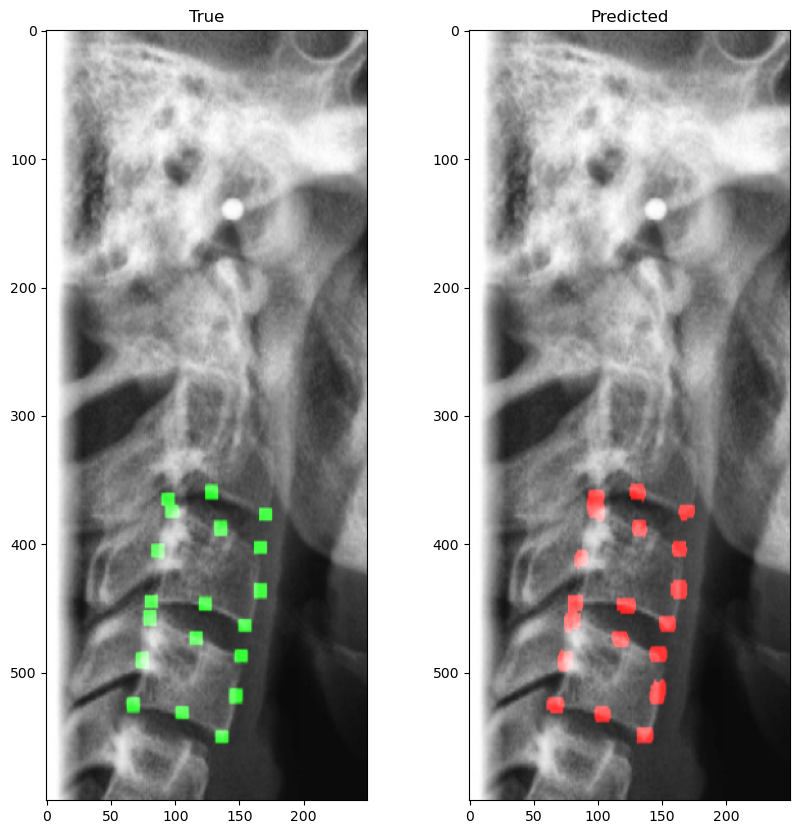

In [28]:


plt.subplot(121)
plt.imshow(resized)
plt.title("True")

# plt.subplot(132)
# plt.imshow(origi_img)
# plt.title("original")

plt.subplot(122)
plt.imshow(im_copy_resized)
plt.title("Predicted")

In [29]:
max_6 = test_images_stacked[6]
min_5 = test_images_stacked[5]
mid_18 = test_images_stacked[16]

max_true_mask = test_masks_stacked[6]
min_true_mask = test_masks_stacked[5]
mid_true_mask = test_masks_stacked[16]


max_pred_mask = pred_masks[6]
min_pred_mask = pred_masks[5]
mid_pred_mask = pred_masks[16]

In [30]:
def convertRGB(image):
    im_gray_convert = image[:,:].astype(np.float32) # cv2 accepts dimension(256,256) and float32
    # convert to RGB
    im_rgb = cv2.cvtColor(im_gray_convert, cv2.COLOR_GRAY2RGB)
    return im_rgb

In [31]:
def drawTwoMasks(image, idx):
    image[:,:,0] = image[:,:,0] + test_masks[idx]
    image[:,:,1] = image[:,:,1] + pred_masks[idx][:,:,0]
    return image

In [32]:
max_6 = convertRGB(max_6)
max_6.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


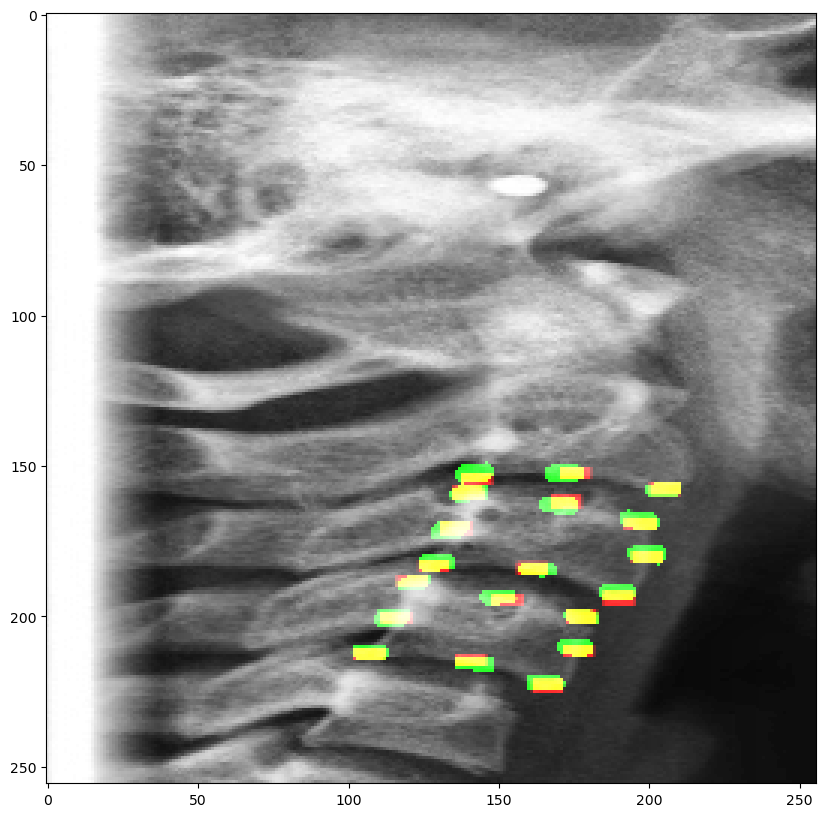

In [33]:
max_6 = drawTwoMasks(max_6,6)
plt.imshow(max_6)

In [34]:
min_5 = convertRGB(min_5)
min_5 = drawTwoMasks(min_5,5)

mid_18 = convertRGB(mid_18)
mid_18 = drawTwoMasks(mid_18,16)

In [35]:
np.unique(test_masks[1] == test_masks_stacked[1])

array([ True])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Min Error')

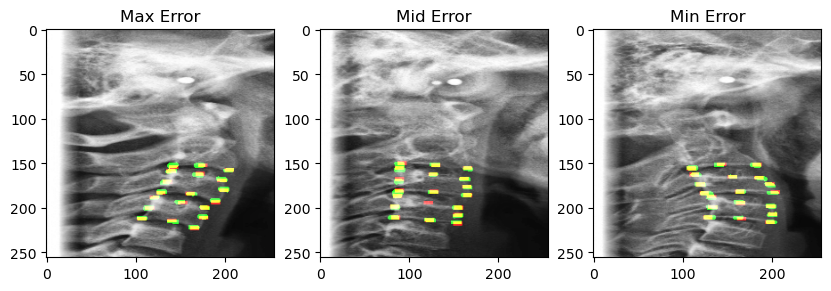

In [36]:
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(131)
plt.imshow(max_6, cmap='gray')
plt.title("Max Error")

plt.subplot(132)
plt.imshow(mid_18, cmap='gray')
plt.title("Mid Error")

plt.subplot(133)
plt.imshow(min_5, cmap='gray')
plt.title("Min Error")

In [37]:
plt.rcParams["figure.figsize"] = (10,10)
max_6 = convertRGB(test_images_stacked[6])
min_5 = convertRGB(test_images_stacked[5])
mid_18 = convertRGB(test_images_stacked[16])

max_6_copy = max_6.copy()
min_5_copy = min_5.copy()
mid_18_copy = mid_18.copy()

max_true_mask = test_masks_stacked[6]
min_true_mask = test_masks_stacked[5]
mid_true_mask = test_masks_stacked[16]

max_pred_mask = pred_masks[6]
min_pred_mask = pred_masks[5]
mid_pred_mask = pred_masks[16]

max_6[:,:,1] = max_6[:,:,1] + max_true_mask
min_5[:,:,1] = min_5[:,:,1] + min_true_mask
mid_18[:,:,1] = mid_18[:,:,1] + mid_true_mask

max_6_copy[:,:,0] = max_6_copy[:,:,0] + max_pred_mask[:,:,0]
min_5_copy[:,:,0] = min_5_copy[:,:,0] + min_pred_mask[:,:,0]
mid_18_copy[:,:,0] = mid_18_copy[:,:,0] + mid_pred_mask[:,:,0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Min Error: Pred')

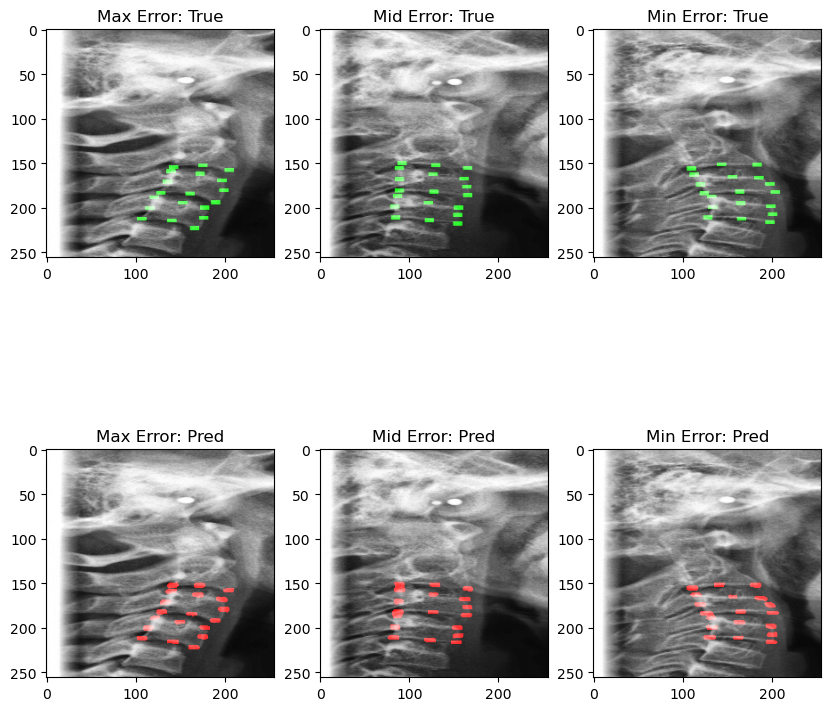

In [38]:
plt.subplot(231)
plt.imshow(max_6)
plt.title("Max Error: True")

plt.subplot(232)
plt.imshow(mid_18)
plt.title("Mid Error: True")

plt.subplot(233)
plt.imshow(min_5)
plt.title("Min Error: True")

plt.subplot(234)
plt.imshow(max_6_copy)
plt.title("Max Error: Pred")

plt.subplot(235)
plt.imshow(mid_18_copy)
plt.title("Mid Error: Pred")

plt.subplot(236)
plt.imshow(min_5_copy, cmap='gray')
plt.title("Min Error: Pred")

In [39]:
unet.evaluate(test_images_stacked, test_masks_stacked)

1/1 [==============================] - 0s 378ms/step - loss: 0.3232 - dice_coeff: 0.6768


[0.3232195973396301, 0.6767804026603699]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Min Error: Pred')

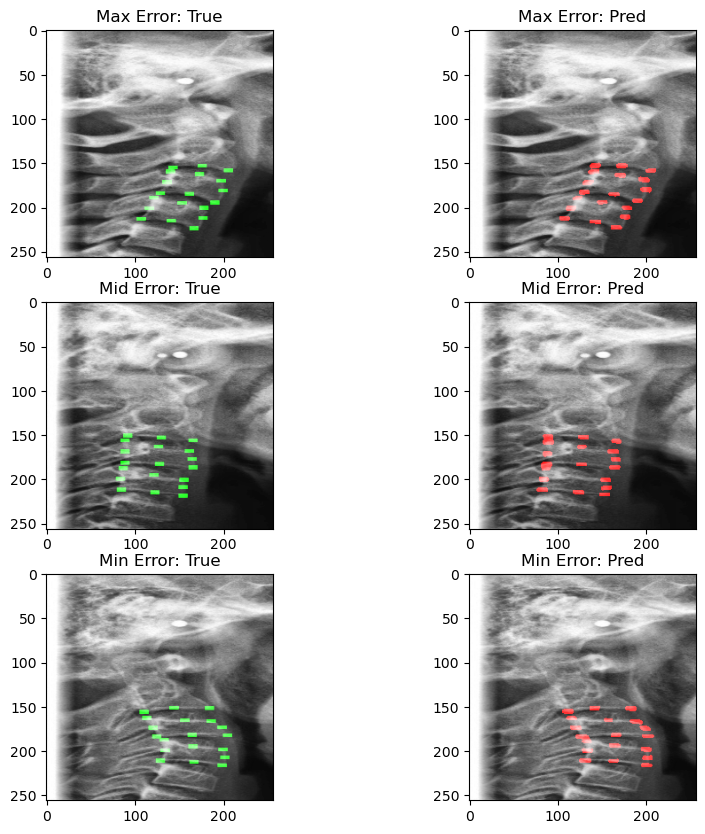

In [40]:
plt.subplot(321)
plt.imshow(max_6)
plt.title("Max Error: True")

plt.subplot(322)
plt.imshow(max_6_copy)
plt.title("Max Error: Pred")

plt.subplot(323)
plt.imshow(mid_18)
plt.title("Mid Error: True")

plt.subplot(324)
plt.imshow(mid_18_copy)
plt.title("Mid Error: Pred")

plt.subplot(325)
plt.imshow(min_5)
plt.title("Min Error: True")

plt.subplot(326)
plt.imshow(min_5_copy)
plt.title("Min Error: Pred")